## Prerequisites

In [1]:
from datasets import keepcontrol
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [2]:
# Global variables
PATH = "/mnt/neurogeriatrics_data/Keep Control/Data/lab dataset/rawdata"
DEMOGRAPHICS_FILE = "/mnt/neurogeriatrics_data/Keep Control/Data/lab dataset/rawdata/participants.tsv"
TRACKED_POINTS = ["left_ankle", "right_ankle"]
CLASSIFICATION_TASK = "phases"
WIN_LEN = 400

## Get the data

In [3]:
ds_train, ds_val, ds_test = keepcontrol.load_data(
    path=PATH,
    filename=DEMOGRAPHICS_FILE,
    tracked_points=TRACKED_POINTS,
    incl_magn=False,
    classification_task=CLASSIFICATION_TASK,
    win_len=WIN_LEN
)

Creating dataset ...


In [4]:
# Split datasets in data and labels
(train_data, train_labels, train_filenames, train_ids) = ds_train
(val_data, val_labels, val_filenames, val_ids) = ds_val

In [5]:
# Shape: (batch_size, win_len, num_channels)
print(f"Shape of train data: {train_data.shape}")
print(f"Shape of train labels: {train_labels.shape}")
print(f"Shape of val data: {val_data.shape}")
print(f"Shape of val labels: {val_labels.shape}")

Shape of train data: (3472, 400, 6)
Shape of train labels: (3472, 400, 1)
Shape of val data: (714, 400, 6)
Shape of val labels: (714, 400, 1)


## Explore the data

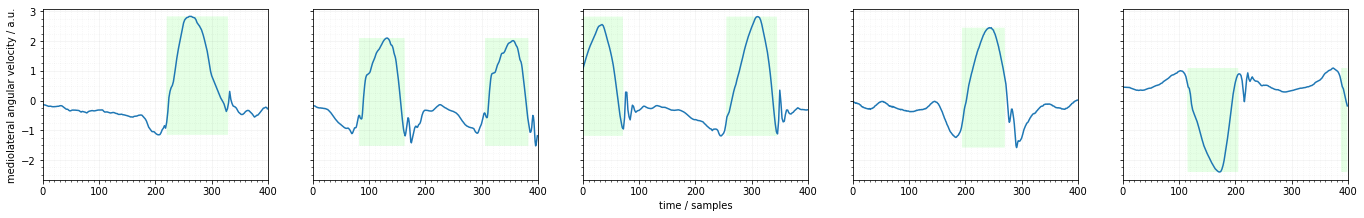

In [6]:
num_examples = 5
indx_random = np.random.choice(train_data.shape[0], num_examples, replace=False)
cm = 1/2.54
fig, axs = plt.subplots(1, num_examples, figsize=(2*29.7*cm, 8*cm), sharey=True)
for (i, indx) in enumerate(indx_random):
    axs[i].fill_between(np.arange(train_labels[indx].shape[0]), train_labels[indx][:,0]*max(train_data[indx][:,5]), color=(0, 1, 0), alpha=0.1, edgecolor='none')
    axs[i].fill_between(np.arange(train_labels[indx].shape[0]), train_labels[indx][:,0]*min(train_data[indx][:,5]), color=(0, 1, 0), alpha=0.1, edgecolor='none')
    axs[i].plot(train_data[indx][:,5])
    axs[i].xaxis.set_minor_locator(plt.MultipleLocator(10))
    axs[i].yaxis.set_minor_locator(plt.MultipleLocator(0.25))
    axs[i].grid(True, which="minor", ls=":", color=(0, 0, 0), alpha=0.05)
    axs[i].grid(True, which="major", color=(0, 0, 0), alpha=0.05)
    axs[i].set_xlim((0, train_data[indx].shape[0]))
axs[0].set_ylabel("mediolateral angular velocity / a.u.")
axs[num_examples//2].set_xlabel("time / samples")
plt.show()

In [7]:
indx_with_nans = []
for indx in range(train_data.shape[0]):
    dmy = np.isnan(train_data[indx])
    if np.sum(np.sum(dmy)) > 0:
        indx_with_nans.append(indx)
        print(f"Example: {indx:d}/{train_data.shape[0]:d} has NaN values. Shape of train data array: {train_data[indx].shape}. Corresponding file: {train_filenames[indx]:s}")

In [8]:
indx_with_nans = []
for indx in range(val_data.shape[0]):
    dmy = np.isnan(val_data[indx])
    if np.sum(np.sum(dmy)) > 0:
        indx_with_nans.append(indx)
        print(f"Example: {indx:d}/{val_data.shape[0]:d} has NaN values. Shape of train data array: {val_data[indx].shape}")

## Build model

In [9]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Dense
from tcn import TCN, tcn_full_summary

In [18]:
def make_model(input_shape):
    
    # Define the layers that make up the architecture
    input_layer = Input(shape=(None, input_shape[-1]), name="input_layer")
    tcn_layer = TCN(padding="same", return_sequences=True, use_skip_connections=True, use_batch_norm=True, name="tcn_layer")(input_layer)
    output_layer = Dense(units=1, activation="sigmoid", name="output_layer")(tcn_layer)
    
    # Define the model
    tcn_model = Model(inputs=input_layer, outputs=output_layer, name="tcn_model")
    
    # Compile the model
    tcn_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
        metrics=[tf.keras.metrics.BinaryAccuracy()]
    )
    return tcn_model

In [19]:
tcn_model = make_model(train_data.shape[1:])
tcn_model.summary()

Model: "tcn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, None, 6)]         0         
                                                                 
 tcn_layer (TCN)             (None, None, 64)          140608    
                                                                 
 output_layer (Dense)        (None, None, 1)           65        
                                                                 
Total params: 140,673
Trainable params: 139,137
Non-trainable params: 1,536
_________________________________________________________________


In [20]:
history = tcn_model.fit(
    x=train_data,
    y=train_labels,
    epochs=5,
    batch_size=64,
    validation_data=(val_data, val_labels)
)

Epoch 1/5
55/55 [==============================] - 5s 36ms/step - loss: 0.3631 - binary_accuracy: 0.9042 - val_loss: 1.5632 - val_binary_accuracy: 0.6676
Epoch 2/5
55/55 [==============================] - 1s 27ms/step - loss: 0.1260 - binary_accuracy: 0.9600 - val_loss: 0.2621 - val_binary_accuracy: 0.9110
Epoch 3/5
55/55 [==============================] - 2s 27ms/step - loss: 0.1032 - binary_accuracy: 0.9648 - val_loss: 0.1823 - val_binary_accuracy: 0.9419
Epoch 4/5
55/55 [==============================] - 1s 27ms/step - loss: 0.0913 - binary_accuracy: 0.9685 - val_loss: 0.1527 - val_binary_accuracy: 0.9529
Epoch 5/5
55/55 [==============================] - 1s 27ms/step - loss: 0.0767 - binary_accuracy: 0.9727 - val_loss: 0.1470 - val_binary_accuracy: 0.9537


In [13]:
history.history

{'loss': [0.42663657665252686,
  0.1550014317035675,
  0.13226357102394104,
  0.1196056604385376,
  0.1111411601305008],
 'binary_accuracy': [0.8568512201309204,
  0.9490862488746643,
  0.9546334743499756,
  0.9581034183502197,
  0.960284411907196],
 'val_loss': [3.192697286605835,
  0.8979681134223938,
  0.4413797855377197,
  0.277106374502182,
  0.2080882340669632],
 'val_binary_accuracy': [0.6230112314224243,
  0.623956561088562,
  0.8141001462936401,
  0.9002730846405029,
  0.9299054741859436]}

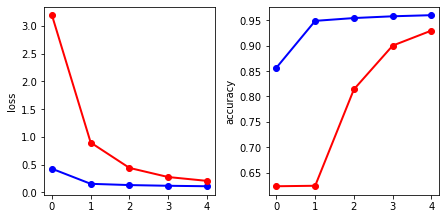

In [17]:
cm = 1/2.54
fig, axs = plt.subplots(1, 2, figsize=(16*cm, 8*cm))
axs[0].plot(history.history["loss"], 'bo-', lw=2, label="training")
axs[0].plot(history.history["val_loss"], 'ro-', lw=2, label="validation")
axs[0].set_ylabel("loss")
axs[1].plot(history.history["binary_accuracy"], 'bo-', lw=2, label="training")
axs[1].plot(history.history["val_binary_accuracy"], 'ro-', lw=2, label="validation")
axs[1].set_ylabel("accuracy")
plt.tight_layout()
plt.show()

In [21]:
predictions = tcn_model.predict(val_data)

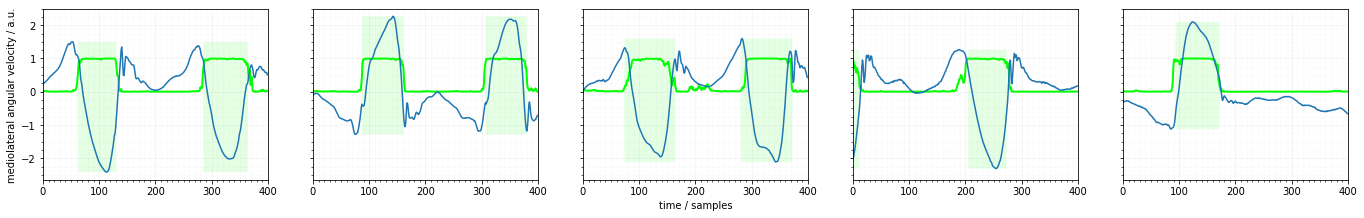

In [29]:
num_examples = 5
indx_random = np.random.choice(val_data.shape[0], num_examples, replace=False)
cm = 1/2.54
fig, axs = plt.subplots(1, num_examples, figsize=(2*29.7*cm, 8*cm), sharey=True)
for (i, indx) in enumerate(indx_random):
    axs[i].fill_between(np.arange(val_labels[indx].shape[0]), val_labels[indx][:,0]*max(val_data[indx][:,5]), color=(0, 1, 0), alpha=0.1, edgecolor='none')
    axs[i].fill_between(np.arange(val_labels[indx].shape[0]), val_labels[indx][:,0]*min(val_data[indx][:,5]), color=(0, 1, 0), alpha=0.1, edgecolor='none')
    axs[i].plot(predictions[indx][:,0], c=(0, 1, 0), lw=2)
    axs[i].plot(val_data[indx][:,5])
    axs[i].xaxis.set_minor_locator(plt.MultipleLocator(10))
    axs[i].yaxis.set_minor_locator(plt.MultipleLocator(0.25))
    axs[i].grid(True, which="minor", ls=":", color=(0, 0, 0), alpha=0.05)
    axs[i].grid(True, which="major", color=(0, 0, 0), alpha=0.05)
    axs[i].set_xlim((0, val_data[indx].shape[0]))
axs[0].set_ylabel("mediolateral angular velocity / a.u.")
axs[num_examples//2].set_xlabel("time / samples")
plt.show()